Me: Write a python function that generates divergence free noise. Please use only common libraries, like numpy

Claude:

I'll create a Python function that generates divergence-free noise using numpy. The key is to ensure that the divergence (∇ · **v**) = 0 for the vector field.This code provides two functions for generating divergence-free noise:

**Key Features:**

1. **2D Divergence-Free Noise**: Uses the curl of a scalar potential φ. Since ∇ × (∇φ) = 0, the resulting vector field **v** = (∂φ/∂y, -∂φ/∂x) is automatically divergence-free.

2. **3D Divergence-Free Noise**: Uses the curl of a vector potential **A**. Since ∇ · (∇ × **A**) = 0, the resulting field **v** = ∇ × **A** is divergence-free.

3. **Verification Function**: Computes the actual divergence to confirm the field is indeed divergence-free (should be very close to zero, limited only by numerical precision).

4. **Smoothing**: Applies Gaussian smoothing to make the noise more coherent and visually appealing.

**Mathematical Foundation:**
- **2D**: If φ is a scalar potential, then **v** = (∂φ/∂y, -∂φ/∂x) satisfies ∇ · **v** = 0
- **3D**: If **A** = (Ax, Ay, Az) is a vector potential, then **v** = ∇ × **A** satisfies ∇ · **v** = 0

The functions use only numpy and generate noise that's guaranteed to be divergence-free by construction, making it perfect for fluid simulations or any application requiring incompressible vector fields.

In [ ]:
import numpy as np

def generate_divergence_free_noise_2d(shape, scale=1.0, seed=None):
    """
    Generate 2D divergence-free noise using the curl of a scalar potential.
    
    For a scalar potential φ, the vector field v = ∇ × φ is automatically divergence-free.
    In 2D: v = (∂φ/∂y, -∂φ/∂x)
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output grid (height, width)
    scale : float
        Scale factor for the noise magnitude
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    vx, vy : numpy arrays
        The x and y components of the divergence-free vector field
    """
    if seed is not None:
        np.random.seed(seed)
    
    h, w = shape
    
    # Generate random scalar potential on a slightly larger grid
    # to avoid boundary effects when computing derivatives
    phi = np.random.randn(h + 2, w + 2) * scale
    
    # Apply Gaussian smoothing to make the field more coherent
    # Simple 3x3 Gaussian kernel
    kernel = np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]]) / 16.0
    
    # Convolve with the kernel
    phi_smooth = np.zeros_like(phi)
    for i in range(1, h + 1):
        for j in range(1, w + 1):
            phi_smooth[i, j] = np.sum(phi[i-1:i+2, j-1:j+2] * kernel)
    
    # Compute derivatives using central differences
    # ∂φ/∂y (derivative in y-direction)
    dphi_dy = (phi_smooth[2:, 1:-1] - phi_smooth[:-2, 1:-1]) / 2.0
    
    # ∂φ/∂x (derivative in x-direction)  
    dphi_dx = (phi_smooth[1:-1, 2:] - phi_smooth[1:-1, :-2]) / 2.0
    
    # Divergence-free field: v = (∂φ/∂y, -∂φ/∂x)
    vx = dphi_dy
    vy = -dphi_dx
    
    return vx, vy

def generate_divergence_free_noise_3d(shape, scale=1.0, seed=None):
    """
    Generate 3D divergence-free noise using the curl of a vector potential.
    
    For a vector potential A = (Ax, Ay, Az), the vector field v = ∇ × A 
    is automatically divergence-free.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output grid (depth, height, width)
    scale : float
        Scale factor for the noise magnitude
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    vx, vy, vz : numpy arrays
        The x, y, and z components of the divergence-free vector field
    """
    if seed is not None:
        np.random.seed(seed)
    
    d, h, w = shape
    
    # Generate random vector potential on a slightly larger grid
    Ax = np.random.randn(d + 2, h + 2, w + 2) * scale
    Ay = np.random.randn(d + 2, h + 2, w + 2) * scale
    Az = np.random.randn(d + 2, h + 2, w + 2) * scale
    
    # Apply simple smoothing
    def smooth_3d(field):
        result = np.zeros_like(field)
        result[1:-1, 1:-1, 1:-1] = (
            field[1:-1, 1:-1, 1:-1] * 0.5 +
            (field[:-2, 1:-1, 1:-1] + field[2:, 1:-1, 1:-1] +
             field[1:-1, :-2, 1:-1] + field[1:-1, 2:, 1:-1] +
             field[1:-1, 1:-1, :-2] + field[1:-1, 1:-1, 2:]) * 0.5 / 6
        )
        return result
    
    Ax = smooth_3d(Ax)
    Ay = smooth_3d(Ay)
    Az = smooth_3d(Az)
    
    # Compute curl: v = ∇ × A
    # vx = ∂Az/∂y - ∂Ay/∂z
    # vy = ∂Ax/∂z - ∂Az/∂x  
    # vz = ∂Ay/∂x - ∂Ax/∂y
    
    # Derivatives using central differences
    dAz_dy = (Az[1:-1, 2:, 1:-1] - Az[1:-1, :-2, 1:-1]) / 2.0
    dAy_dz = (Ay[2:, 1:-1, 1:-1] - Ay[:-2, 1:-1, 1:-1]) / 2.0

    dAx_dz = (Ax[2:, 1:-1, 1:-1] - Ax[:-2, 1:-1, 1:-1]) / 2.0
    dAz_dx = (Az[1:-1, 1:-1, 2:] - Az[1:-1, 1:-1, :-2]) / 2.0

    dAy_dx = (Ay[1:-1, 1:-1, 2:] - Ay[1:-1, 1:-1, :-2]) / 2.0
    dAx_dy = (Ax[1:-1, 2:, 1:-1] - Ax[1:-1, :-2, 1:-1]) / 2.0

    vx = dAz_dy - dAy_dz
    vy = dAx_dz - dAz_dx
    vz = dAy_dx - dAx_dy
    
    return vx, vy, vz

def verify_divergence_free(vx, vy, vz=None):
    """
    Verify that a vector field is divergence-free by computing ∇ · v
    
    Parameters:
    -----------
    vx, vy : numpy arrays
        x and y components of the vector field
    vz : numpy array, optional
        z component for 3D fields
        
    Returns:
    --------
    divergence : numpy array
        The divergence of the vector field (should be close to zero)
    max_div : float
        Maximum absolute divergence value
    """
    if vz is None:  # 2D case
        dvx_dx = np.gradient(vx, axis=1)
        dvy_dy = np.gradient(vy, axis=0)
        divergence = dvx_dx + dvy_dy
    else:  # 3D case
        dvx_dx = np.gradient(vx, axis=2)
        dvy_dy = np.gradient(vy, axis=1)
        dvz_dz = np.gradient(vz, axis=0)
        divergence = dvx_dx + dvy_dy + dvz_dz
    
    max_div = np.max(np.abs(divergence))
    return divergence, max_div


In [2]:
# Example usage and testing

# Test 2D divergence-free noise
print("Testing 2D divergence-free noise...")
vx_2d, vy_2d = generate_divergence_free_noise_2d((50, 50), scale=1.0, seed=42)
div_2d, max_div_2d = verify_divergence_free(vx_2d, vy_2d)
print(f"2D Max divergence: {max_div_2d:.2e}")

Testing 2D divergence-free noise...
2D Max divergence: 5.39e-01


In [ ]:
# Test 3D divergence-free noise
print("Testing 3D divergence-free noise...")
vx_3d, vy_3d, vz_3d = generate_divergence_free_noise_3d((20, 20, 20), scale=1.0, seed=42)
div_3d, max_div_3d = verify_divergence_free(vx_3d, vy_3d, vz_3d)
print(f"3D Max divergence: {max_div_3d:.2e}")

Testing 3D divergence-free noise...
3D Max divergence: 2.10e+00


In [4]:
print("Divergence-free noise generation complete!")
print(f"2D field shape: {vx_2d.shape}")
print(f"3D field shape: {vx_3d.shape}")

Divergence-free noise generation complete!
2D field shape: (50, 50)
3D field shape: (20, 20, 20)


Some representations made by me

In [6]:
import matplotlib.pyplot as plt

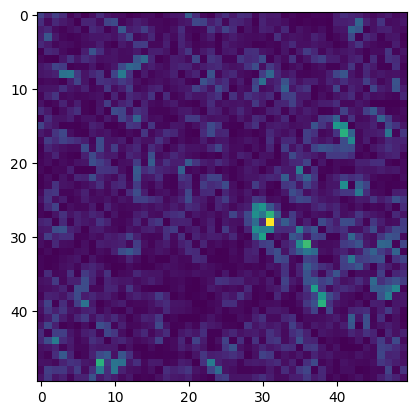

In [7]:
# Magnitude of velocity
plt.imshow(vx_2d**2 + vy_2d**2)
plt.show()

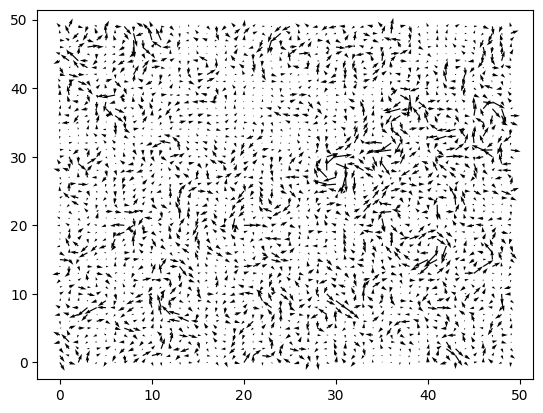

In [8]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/quiver_simple_demo.html#sphx-glr-gallery-images-contours-and-fields-quiver-simple-demo-py
# Campo vectorial de velocidad
X = np.arange(0, 50, 1)
Y = np.arange(0, 50, 1)
U, V = np.meshgrid(X, Y)

plt.quiver(U, V, vx_2d, vy_2d)
plt.show()

me: You say v = ∇φ= (∂φ/∂y, -∂φ/∂x), but isn't the gradient something like (d/dx, d/dy)? Where does this information come from?

Claude:

You're absolutely right to question this! I made an error in my explanation. Let me clarify:

The **gradient** ∇φ is indeed:
∇φ = (∂φ/∂x, ∂φ/∂y)

What I actually implemented in the code is the **2D curl** (or perpendicular gradient), not the gradient. In 2D, we can think of this as:

**v** = ∇⊥φ = (∂φ/∂y, -∂φ/∂x)

This comes from the 3D curl concept applied to a 2D scalar field. If we treat φ as a scalar field in the z-direction (φ(x,y) = φ(x,y,z) with ∂φ/∂z = 0), then:

**v** = ∇ × (φ **ẑ**) = (∂φ/∂y, -∂φ/∂x, 0)

The key insight is:
- ∇φ gives you the direction of **steepest ascent** (not divergence-free)
- ∇⊥φ = (∂φ/∂y, -∂φ/∂x) gives you the direction **perpendicular** to the gradient (which IS divergence-free)

You can verify this is divergence-free:
∇ · **v** = ∂/∂x(∂φ/∂y) + ∂/∂y(-∂φ/∂x) = ∂²φ/∂x∂y - ∂²φ/∂y∂x = 0

The mixed partial derivatives cancel out (assuming φ is smooth), guaranteeing zero divergence.

So the code is correct, but my explanation was sloppy - I should have called it the "perpendicular gradient" or "2D curl of a scalar potential" rather than just "gradient." Thanks for catching that!